<a href="https://colab.research.google.com/github/Divyanshi-negi/Parkinson/blob/main/Parkinsons_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'parkison-diseases-eeg-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4267056%2F7348338%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240827%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240827T115245Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D85c8f9b1a0139f100035773ea5e1d59fdf71759e36e1a2a2e2e2fa8010c9035ae35d01c026a80fea931a81667638424f496ab8ba5868fc9750eba2532e059231a3496a724242bc744b469f530dcdd1ef323071990d00bc5788ac24c4b380935a08503c28faa518109ebfbbd83dc6bf4e40c92d30b9d631615beef7e529239e4b2870043f6e5e20c098d905bf66e31e305f3d94a3402b0ce5f4dc45d3c2deb9f4ed59733c35282a252117ac281f310b42ffdd335d02e6325aede8ef7c1f3ff9a40da9e5763f3547145c2b608f8ed82785324778207c42757c5a12a15ac54e513c409d6d74fb2912174350d7a0a3b9da034f7a3bb54839c4fb2d40cc798f98f1d8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2297371 bytes downloaded
Downloaded and uncompressed: parkison-diseases-eeg-dataset
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv('/kaggle/input/parkison-diseases-eeg-dataset/pd_EEG_features.csv')

/kaggle/input/parkison-diseases-eeg-dataset/pd_EEG_features.csv


This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds to one of 195 voice recordings from these individuals ("name" column). The main aim of the data is to discriminate healthy people from those with PD, according to the "status" column which is set to 0 for healthy and 1 for PD.

Attribute Information: Matrix column entries (attributes): name - ASCII subject name and recording number MDVP:Fo(Hz) - Average vocal fundamental frequency MDVP:Fhi(Hz) - Maximum vocal fundamental frequency MDVP:Flo(Hz) - Minimum vocal fundamental frequency MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP - Several measures of variation in fundamental frequency MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude NHR, HNR - Two measures of the ratio of noise to tonal components in the voice status - The health status of the subject (one) - Parkinson's, (zero) - healthy RPDE, D2 - Two nonlinear dynamical complexity measures DFA - Signal fractal scaling exponent spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation

In [ ]:
df.head()

,id,gender,PPE,EEG,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [ ]:
df.shape

(756, 755)

# Is the data well balanced?

<Axes: xlabel='class', ylabel='count'>

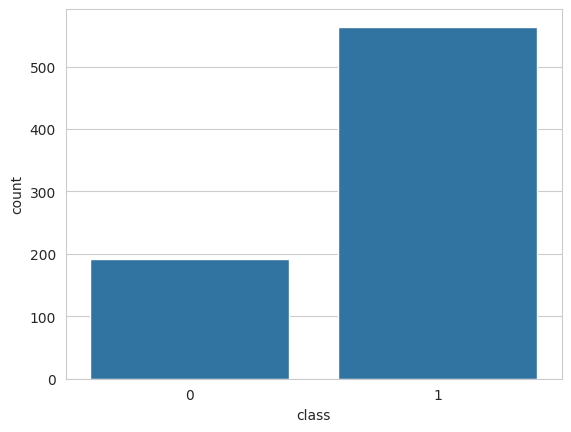

In [ ]:
sns.countplot(x=df['class'])   # Data is not well balanced, this will effect the accuracy of any model

In [ ]:
positive = (df['class'] == 1).sum()/len(df['class'])*100
print(f'Proportion of data points which are positive for Parkinsons Disease is: ', '{:.2f}'.format(positive), '%')
print('The data is not well balanced, this will effect the accuracy of any model.')

Proportion of data points which are positive for Parkinsons Disease is:  74.60 %
The data is not well balanced, this will effect the accuracy of any model.


# What is the gender divide?

<Axes: xlabel='gender', ylabel='count'>

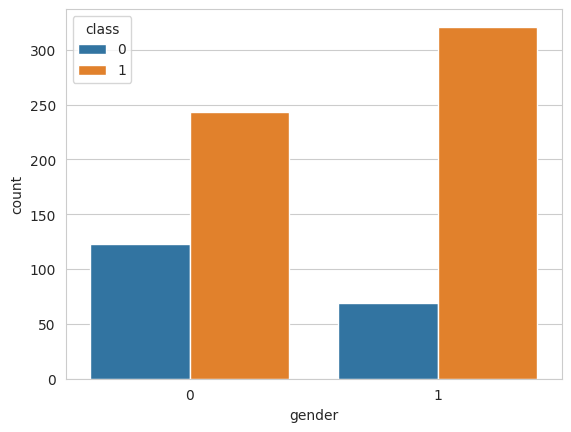

In [ ]:
sns.countplot(x=df['gender'], hue = df['class'])

There are roughly equal numbers of males and females in the study.  At the time of writing we do not know which way around the gender coding has been set.

In [ ]:
df.isnull().sum().sum()

0

There are no null values in the dataframe, and all entries are either of float or integer data type.

In [ ]:
duplicates = df.duplicated()
duplicates.sum()

1

In [ ]:
df.drop_duplicates(keep='first')

,id,gender,PPE,EEG,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,250,0,0.80903,0.56355,0.28385,417,416,0.004627,0.000052,0.00064,...,3.0706,3.0190,3.1212,2.4921,3.5844,3.5400,3.3805,3.2003,6.8671,0
752,250,0,0.16084,0.56499,0.59194,415,413,0.004550,0.000220,0.00143,...,1.9704,1.7451,1.8277,2.4976,5.2981,4.2616,6.3042,10.9058,28.4170,0
753,251,0,0.88389,0.72335,0.46815,381,380,0.005069,0.000103,0.00076,...,51.5607,44.4641,26.1586,6.3076,2.8601,2.5361,3.5377,3.3545,5.0424,0
754,251,0,0.83782,0.74890,0.49823,340,339,0.005679,0.000055,0.00092,...,19.1607,12.8312,8.9434,2.2044,1.9496,1.9664,2.6801,2.8332,3.7131,0


There was one duplicate row, and this has now been dropped.

# Discussion - Data PreProcessing
Given the large number of features that are included in the dataframe, it is necessary to perform some kind of dimensionality reduction.  For this we are going to use Principle Component Analysis.

There are a relatively small number of patients involved in the study, too few to consider any averaging of the features gathered for each patient.  Therefore we will consider each row as it is.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop('class', axis=1)

In [ ]:
y = df['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.25, random_state=42)

In [ ]:
# It is necessary to Normalise the data before PCA using StandardScaler.
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

np.mean(X_train), np.std(X_train), np.mean(X_test), np.std(X_test)

(6.915284155011557e-16,
 1.0000000000000002,
 -0.006908548717029101,
 1.0911611128221876)

In [ ]:
# Loading the PCA module:
from sklearn.decomposition import PCA

my_PCA = PCA(n_components=2)
X_train_pca = my_PCA.fit_transform(X_train)
X_test_pca = my_PCA.transform(X_test)

In [ ]:
X_train_Df = pd.DataFrame(data = X_train_pca, columns = ['principal component 1', 'principal component 2'])

In [ ]:
X_train_Df.head()

,principal component 1,principal component 2
0,-16.269882,-4.213320
1,-3.789291,-14.762454
2,8.458925,-16.535228
3,6.882258,-5.117388
4,-2.228182,13.730601


In [ ]:
print('Explained variation per principal component: {}'.format(my_PCA.explained_variance_ratio_))

Explained variation per principal component: [0.13155992 0.09279559]


This analysis shows that principal comonent 1 contains 13% of the explained variance, and principal component 2 only another 9%.  This will be insufficient to get a good model; more principal components will be needed.


<Axes: xlabel='principal component 1', ylabel='principal component 2'>

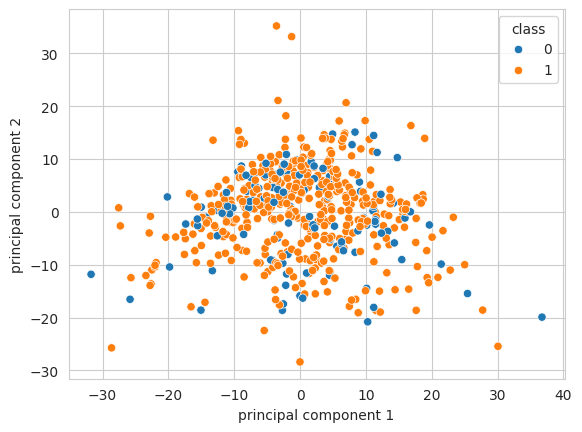

In [ ]:
# Plotting the two principal components against each other
sns.scatterplot(data=X_train_Df, x='principal component 1', y='principal component 2', hue=df['class'])

<Axes: xlabel='principal component 1', ylabel='principal component 2'>

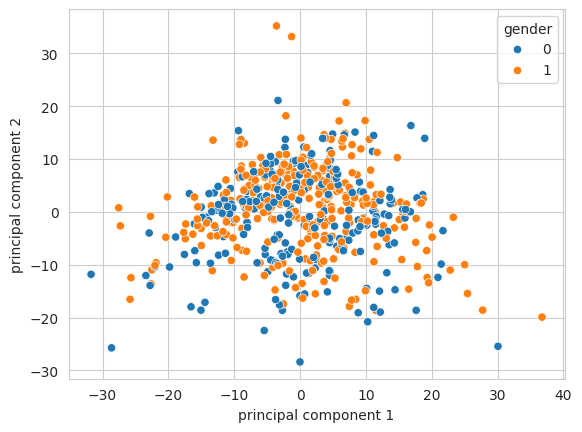

In [ ]:
# Plotting the two principal components against each other
sns.scatterplot(data=X_train_Df, x='principal component 1', y='principal component 2', hue=df['gender'])

The first scatterplot shows that there is little separation of those positive and negative with Parkinson's Disease identifed in the first two principal components.  The second plot was created just because we could.  It similarly shows no real separation between genders.

# Perform Logistic Regression

In [ ]:
# This time we request that 90% of the variance is retained by allowing as many principal components as necessary

my_PCA = PCA(0.8)
X_train_pca = my_PCA.fit_transform(X_train)
X_test_pca = my_PCA.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_model = LogisticRegression()
log_model.fit(X_train_pca, y_train)

LogisticRegression()

In [ ]:
predictions = log_model.predict(X_test_pca)

## Analysing Logistic Regression Model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.57      0.64        51
           1       0.85      0.93      0.89       138

    accuracy                           0.83       189
   macro avg       0.80      0.75      0.77       189
weighted avg       0.82      0.83      0.82       189



In [ ]:
print(confusion_matrix(y_test, predictions, labels = [1,0]))

[[128  10]
 [ 22  29]]


# ANN Model
Let's look to see if a neural network model can give improved predictions of Parkinson's Disease

In [ ]:
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode ='min', verbose=1, patience=15)

In [ ]:
model = Sequential()
model.add(Dense(150, activation = 'relu'))
model.add(Dense(75, activation = 'relu'))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = 'adam')

Shape of X_train_pca: (567, 55)
Shape of X_test_pca: (189, 55)
Epoch 1/600
18/18 [==============================] - 2s 23ms/step - loss: 0.5024 - accuracy: 0.7795 - val_loss: 0.3879 - val_accuracy: 0.8571
Epoch 2/600
18/18 [==============================] - 0s 8ms/step - loss: 0.3333 - accuracy: 0.8501 - val_loss: 0.3794 - val_accuracy: 0.8571
Epoch 3/600
18/18 [==============================] - 0s 22ms/step - loss: 0.2559 - accuracy: 0.8854 - val_loss: 0.3575 - val_accuracy: 0.8677
Epoch 4/600
18/18 [==============================] - 0s 16ms/step - loss: 0.2016 - accuracy: 0.9101 - val_loss: 0.3408 - val_accuracy: 0.8783
Epoch 5/600
18/18 [==============================] - 0s 10ms/step - loss: 0.1656 - accuracy: 0.9436 - val_loss: 0.3437 - val_accuracy: 0.8730
Epoch 6/600
18/18 [==============================] - 0s 4ms/step - loss: 0.1328 - accuracy: 0.9559 - val_loss: 0.3429 - val_accuracy: 0.8677
Epoch 7/600
18/18 [==============================] - 0s 5ms/step - loss: 0.1045 - accur

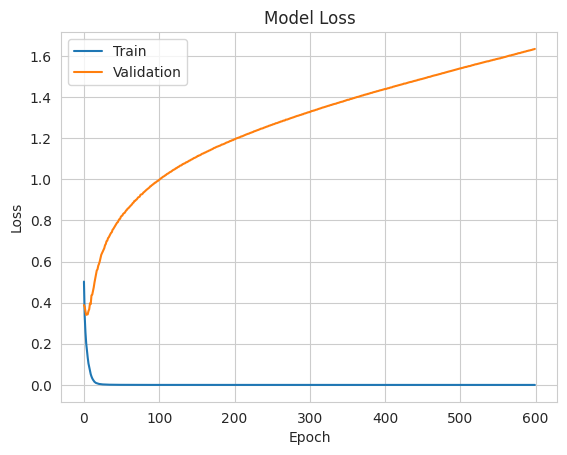

6/6 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        51
           1       0.89      0.91      0.90       138

    accuracy                           0.86       189
   macro avg       0.82      0.81      0.82       189
weighted avg       0.85      0.86      0.86       189

[[126  12]
 [ 15  36]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Print the shape of the PCA-transformed data
print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of X_test_pca:", X_test_pca.shape)

# Define the model
model = Sequential()
model.add(Dense(150, activation='relu', input_shape=(X_train_pca.shape[1],)))  # Input shape based on PCA output
model.add(Dense(75, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define EarlyStopping with increased patience
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=600)

# Train the model with the adjusted patience
history = model.fit(
    x=X_train_pca, y=y_train,
    epochs=600,
    validation_data=(X_test_pca, y_test),
    callbacks=[early_stop]
)

# Plot training & validation loss values
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model
predict = (model.predict(X_test_pca) > 0.5).astype('int32')

# Print classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predict))
print(confusion_matrix(y_test, predict, labels=[1, 0]))


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 150)               8400      
                                                                 
 dense_21 (Dense)            (None, 75)                11325     
                                                                 
 dense_22 (Dense)            (None, 25)                1900      
                                                                 
 dense_23 (Dense)            (None, 1)                 26        
                                                                 
Total params: 21651 (84.57 KB)
Trainable params: 21651 (84.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#losses = pd.DataFrame(model.history.history).plot()

In [ ]:
predict = (model.predict(X_test_pca)>0.5).astype('int32')

6/6 [==============================] - 0s 3ms/step


## Analysing ANN Model

In [ ]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.74      0.69      0.71        51
           1       0.89      0.91      0.90       138

    accuracy                           0.85       189
   macro avg       0.82      0.80      0.81       189
weighted avg       0.85      0.85      0.85       189



In [ ]:
print(confusion_matrix(y_test, predict, labels = [1,0]))

[[126  12]
 [ 16  35]]


After my first draft of this notebook, I have returned and done some work to optimise the ANN model, increasing the number of starting neurons, adding a layer and experimenting with drop out layers.  The dropout layers gave no benefit, but I have retained the first two modifications.  With these, the ANN now gives better results than the logistic regression.

Precision:
    Out of all the candidates that the model predicted would have Parkinson's Disease, 91% actually did (85% for Logistic Regression model).
    Out of all the candidates that the model predicted would not have Parkinson's Disease, 81% of those did not have Parkinson's Disease (74% for logistic regression).

Recall:
    Out of all the candidates that actually did have Parkinson's Disease, the model predicted this outcome correctly for 93% (92% for logistic regression).
    However, out of all the candidates did not have Parkinson's Disease, the model predicted this outcome correctly for 75% (57% for logistic regression).
    
In the confusion matrix, the false negative figure of 9 out of 189, and the false positive figure of 13 out of 189 might be considered too high, depending upon where this test is used alongside others.  Clinicians, after all, will want to avoid giving either the false hope or unnecessary short term stress that an incorrect model output would give.
    
In considering these results, it is important to keep in mind that the data constituted positive tests in 75% of the tests done.  This imbalance will clearly effect the accuracy of the model, and in this light the recall and precision results for positive predictions are encouraging.  In addition to the data inbalance I suspect that there are significant correlations between different features in the dataset, which are compromising the usefulness of the data. I shall leave it to other Kagglers to find an elegant method to hunt these out among the 755 features!
    
Overall, one might conclude that this model could be a good, rapid first check that suggests that further tests should be done, or a final confirmation when all other tests suggest a positive result.  However, it is not good enough to be a diagnostic tool in itself.

# Conclusions
With a highly unbalanced dataset, it is not suprising that a highly accurate model cannot be achieved.

Using PCA to reduce the dimensionality of the dataset did not result in significantly improved predictions.

This is suggestive of highly correlated features, which should be removed to improve the accuracy of a model.

Overall, clinicians might want to use the model as a first good check suggesting that further investigation is warranted, but it is not a diagntic tool.

# **FNN**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Load the dataset
df = pd.read_csv('/kaggle/input/parkison-diseases-eeg-dataset/pd_EEG_features.csv')

# Data Preprocessing
X = df.drop('class', axis=1)
y = df['class']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the Feedforward Neural Network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.4f}')

# Print model summary
model.summary()

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype('int32')

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Epoch 1/50
15/15 [==============================] - 3s 34ms/step - loss: 0.4948 - accuracy: 0.7660 - val_loss: 0.4458 - val_accuracy: 0.8158
Epoch 2/50
15/15 [==============================] - 0s 18ms/step - loss: 0.2863 - accuracy: 0.8918 - val_loss: 0.3696 - val_accuracy: 0.8596
Epoch 3/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1730 - accuracy: 0.9249 - val_loss: 0.3703 - val_accuracy: 0.8596
Epoch 4/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0999 - accuracy: 0.9735 - val_loss: 0.3631 - val_accuracy: 0.8509
Epoch 5/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0563 - accuracy: 0.9912 - val_loss: 0.3408 - val_accuracy: 0.8421
Epoch 6/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0346 - accuracy: 0.9956 - val_loss: 0.4329 - val_accuracy: 0.8421
Epoch 7/50
15/15 [==============================] - 0s 16ms/step - loss: 0.0182 - accuracy: 0.9978 - val_loss: 0.3764 - val_accuracy: 0.8596
Epoch 8/50
15

# GBMs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

# Load the dataset
df = pd.read_csv('/kaggle/input/parkison-diseases-eeg-dataset/pd_EEG_features.csv')

# Data Preprocessing
X = df.drop('class', axis=1)
y = df['class']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the Gradient Boosting Machine model
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gbm_model.fit(X_train, y_train)

# Evaluate the model
y_pred = gbm_model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy:.4f}')

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8677
Confusion Matrix:
[[ 30  21]
 [  4 134]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.59      0.71        51
           1       0.86      0.97      0.91       138

    accuracy                           0.87       189
   macro avg       0.87      0.78      0.81       189
weighted avg       0.87      0.87      0.86       189

